In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib as pl
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'

In [2]:
BATCH_SIZE = 256
IMAGE_SIZE = (224, 224)
IMG_SHAPE = IMAGE_SIZE + (3,)

In [3]:
data_dir = pl.Path(data_path + 'X Ray Images')

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 4672 files belonging to 3 classes.
Using 3504 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 4672 files belonging to 3 classes.
Using 1168 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [7]:
val_bs = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_bs // 5)
val_ds = val_ds.skip(val_bs // 5)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 4
Number of test batches: 1


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [10]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 7, 7, 1280)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 3)


In [16]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 1e-03
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
len(model.trainable_variables)

2

In [20]:
loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 4s 225ms/step - loss: 1.1135 - accuracy: 0.4945
initial loss: 1.11
initial accuracy: 0.49


In [21]:
initial_epochs = 20
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20
14/14 [==============================] - 10s 395ms/step - loss: 1.0808 - accuracy: 0.4926 - val_loss: 0.8383 - val_accuracy: 0.6502
Epoch 2/20
14/14 [==============================] - 8s 376ms/step - loss: 0.8420 - accuracy: 0.6361 - val_loss: 0.7604 - val_accuracy: 0.6711
Epoch 3/20
14/14 [==============================] - 8s 356ms/step - loss: 0.7642 - accuracy: 0.6844 - val_loss: 0.7020 - val_accuracy: 0.7083
Epoch 4/20
14/14 [==============================] - 8s 346ms/step - loss: 0.7203 - accuracy: 0.6966 - val_loss: 0.6833 - val_accuracy: 0.7105
Epoch 5/20
14/14 [==============================] - 8s 349ms/step - loss: 0.6871 - accuracy: 0.7126 - val_loss: 0.6419 - val_accuracy: 0.7314
Epoch 6/20
14/14 [==============================] - 8s 373ms/step - loss: 0.6695 - accuracy: 0.7249 - val_loss: 0.6416 - val_accuracy: 0.7401
Epoch 7/20
14/14 [==============================] - 8s 396ms/step - loss: 0.6474 - accuracy: 0.7352 - val_loss: 0.6497 - val_accuracy: 0.7248
Epoch

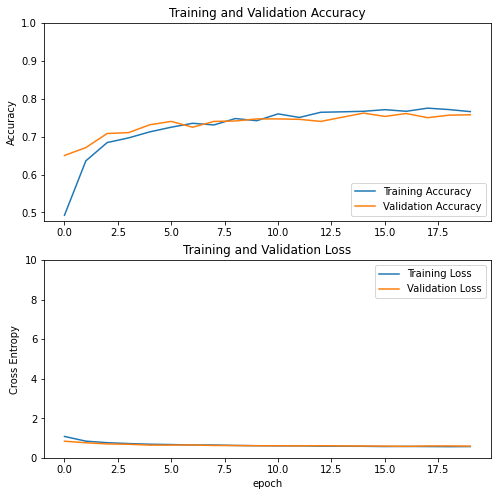

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [26]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 416,643
Non-trainable params: 1,845,184
_________________________________________________________________


In [28]:
len(model.trainable_variables)

7

In [29]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 20/40
14/14 [==============================] - 10s 386ms/step - loss: 0.5552 - accuracy: 0.7754 - val_loss: 0.5811 - val_accuracy: 0.7566
Epoch 21/40
14/14 [==============================] - 8s 361ms/step - loss: 0.5355 - accuracy: 0.7845 - val_loss: 0.5907 - val_accuracy: 0.7522
Epoch 22/40
14/14 [==============================] - 8s 346ms/step - loss: 0.5183 - accuracy: 0.7925 - val_loss: 0.5512 - val_accuracy: 0.7643
Epoch 23/40
14/14 [==============================] - 8s 343ms/step - loss: 0.4981 - accuracy: 0.8068 - val_loss: 0.5347 - val_accuracy: 0.7730
Epoch 24/40
14/14 [==============================] - 8s 341ms/step - loss: 0.4875 - accuracy: 0.8045 - val_loss: 0.5478 - val_accuracy: 0.7654
Epoch 25/40
14/14 [==============================] - 8s 363ms/step - loss: 0.4731 - accuracy: 0.8114 - val_loss: 0.5764 - val_accuracy: 0.7566
Epoch 26/40
14/14 [==============================] - 8s 383ms/step - loss: 0.4709 - accuracy: 0.8062 - val_loss: 0.5383 - val_accuracy: 0.771

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

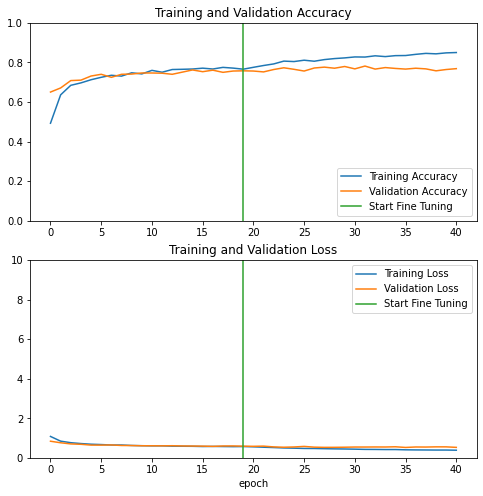

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 10.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.6183 - accuracy: 0.7422
Test accuracy : 0.7421875


In [33]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [34]:
predictions = tf.math.argmax(predictions, axis=1)

In [35]:
label_batch = tf.math.argmax(label_batch, axis=1)

Predictions:
 tf.Tensor(
[2 1 1 1 1 1 1 1 0 1 0 2 1 1 1 1 1 1 1 2 1 1 0 1 2 1 1 0 2 0 2 1 0 2 2 0 1
 0 2 1 0 1 0 1 1 2 2 1 1 1 1 1 2 2 1 0 1 1 1 1 1 1 0 1 2 1 0 1 1 0 0 1 1 0
 1 0 1 1 0 1 2 0 1 1 1 2 1 1 1 1 0 2 1 1 0 1 1 2 2 0 0 0 0 2 2 1 1 1 1 1 1
 0 0 0 0 2 1 1 1 1 0 1 1 2 0 1 0 0 1 1 1 1 1 1 1 1 2 0 1 0 1 1 1 2 1 2 1 0
 1 0 0 1 1 1 1 0 0 1 1 0 0 2 1 2 1 1 1 0 1 1 2 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 2 0 2 1 1 1 1 0 1 1 2 0 1 2 2 2 0 1 2 1 0 1 0 0 0 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 2 1 2 1 0 0 2 1 1 1 1 1 2 2 1 1], shape=(256,), dtype=int64)
Labels:
 tf.Tensor(
[1 2 1 2 2 2 1 1 0 1 0 2 1 1 1 2 2 2 2 2 2 2 0 1 1 1 1 0 2 0 2 1 0 2 1 0 1
 0 2 2 0 1 0 1 1 2 2 1 2 1 1 2 2 1 1 0 1 1 2 0 1 1 0 1 2 1 0 1 2 0 2 1 1 2
 1 2 1 0 1 2 2 0 1 1 1 2 1 1 2 2 0 0 1 1 1 1 1 1 2 0 0 0 0 2 2 1 1 1 1 2 1
 0 0 0 0 1 1 0 2 1 0 1 1 1 0 1 0 0 0 1 2 1 1 1 1 1 2 0 1 0 1 1 2 1 1 2 2 2
 1 0 0 1 1 0 2 0 0 2 2 0 0 2 1 2 1 1 1 0 0 1 2 0 0 1 1 1 1 2 1 0 1 2 1 1 1
 1 1 2 0 2 0 2 1 2 1 2 0 1 1 2 0

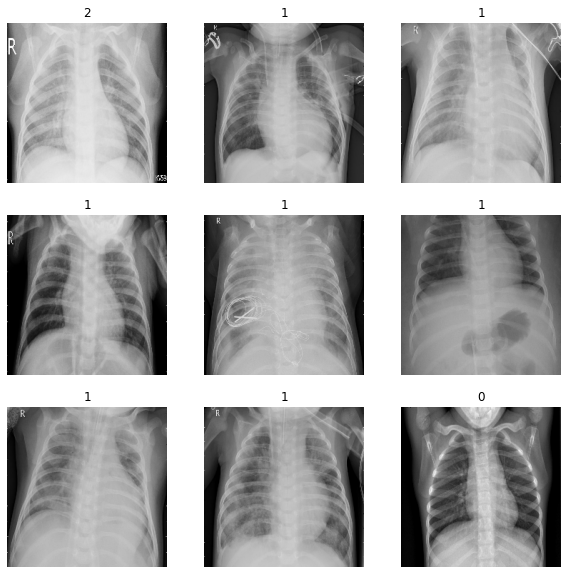

In [37]:
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [38]:
model.save('x_ray_keras_mobilenet_v2')

INFO:tensorflow:Assets written to: x_ray_keras_mobilenet_v2\assets


In [4]:
new_model = tf.keras.models.load_model('x_ray_keras_mobilenet_v2')

In [40]:
import tf2onnx
import onnxruntime as rt

In [41]:
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "x_ray_keras_mobilenet_v2.onnx"

model_proto, _ = tf2onnx.convert.from_keras(new_model, input_signature=spec, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [3]:
from tensorflow.keras.preprocessing import image
img_path = 'C:/Users/light/Desktop/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [5]:
probs = new_model.predict_proba(x) 
preds = new_model.predict(x)
preds = tf.math.argmax(preds, axis=1)
preds, probs

AttributeError: 'Functional' object has no attribute 'predict_proba'

In [46]:

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred = m.run(output_names, {"input": x})

onnx_pred= tf.math.argmax(onnx_pred[0], axis=1)

print('ONNX Predicted:', onnx_pred)

# make sure ONNX and keras have the same results
np.testing.assert_allclose(preds, onnx_pred)

ONNX Predicted: tf.Tensor([1], shape=(1,), dtype=int64)
